# Deep Learning

In [1]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import regularizers
import keras
import pandas as pd
import numpy as np
from keras import backend as K
from keras import metrics
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

Using TensorFlow backend.


In [2]:
kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")

#y_train_labels = pd.read_pickle("dataset/kdd_train_2labels_y.pkl")
#y_train_labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
#y_test_labels = pd.read_pickle("dataset/kdd_test_2labels_y.pkl")

output_columns_2labels = ['is_Attack','is_Normal']

from sklearn import model_selection as ms
from sklearn import preprocessing as pp

x_input = kdd_train_2labels.drop(output_columns_2labels, axis = 1)
y_output = kdd_train_2labels.loc[:,output_columns_2labels]

ss = pp.StandardScaler()
x_input = ss.fit_transform(x_input)

#le = pp.LabelEncoder()
#y_train = le.fit_transform(y_train_labels).reshape(-1, 1)
#y_test = le.transform(y_test_labels).reshape(-1, 1)

y_train = kdd_train_2labels.loc[:,output_columns_2labels].values

x_train, x_valid, y_train, y_valid = ms.train_test_split(x_input, 
                              y_train, 
                              test_size=0.1)
#x_valid, x_test, y_valid, y_test = ms.train_test_split(x_valid, y_valid, test_size = 0.4)

x_test = kdd_test_2labels.drop(output_columns_2labels, axis = 1)
y_test = kdd_test_2labels.loc[:,output_columns_2labels].values

x_test = ss.transform(x_test)

#x_train = np.hstack((x_train, y_train))
#x_valid = np.hstack((x_valid, y_valid))

#x_test = np.hstack((x_test, np.random.normal(loc = 0, scale = 0.01, size = y_test.shape)))

In [3]:
input_dim = 122
intermediate_dim = 10
latent_dim = 32
batch_size = 1409
epochs = 5
hidden_layers = 8
classes = 2

class Train:
    def train():
        Train.x = Input(shape=(input_dim,))
        
        hidden_encoder = Train.x
        for i in range(hidden_layers):
            hidden_encoder = Dense(intermediate_dim, activation='relu')(hidden_encoder)
            

        mean_encoder = Dense(latent_dim, activation=None)(hidden_encoder)

        logvar_encoder = Dense(latent_dim, activation=None)(hidden_encoder)

        def get_distrib(args):

            mean_encoder, logvar_encoder = args

            # Sample epsilon
            epsilon = np.random.normal(loc=0.0, scale=0.05, size = (batch_size, latent_dim))

            # Sample latent variable
            z = mean_encoder + K.exp(logvar_encoder / 2) * epsilon
            return z

        z = Lambda(get_distrib)([mean_encoder, logvar_encoder])

        hidden_decoder = z
        for i in range(hidden_layers):
            hidden_decoder = Dense(intermediate_dim, activation="relu")(hidden_decoder)

        Train.x_ = Dense(input_dim, activation=None, name='vae_output')(hidden_decoder)
        
        hidden_y = Dense(latent_dim, activation='softmax', name='softmax_hidden')(z)
        
        Train.y = Dense(classes, activation='softmax', name='softmax_output')(hidden_y)
        

def get_loss(x, x_):
    xent_loss = input_dim * metrics.binary_crossentropy(x, x_) 
    kl_loss = - 0.5 * K.sum(1 + logvar_encoder - K.square(mean_encoder) - K.exp(logvar_encoder), axis=-1)
    
    return K.abs(K.mean(xent_loss + kl_loss + label_loss))



In [4]:
import itertools
#features_arr = [4, 16, 32, 256, 1024]
#hidden_layers_arr = [2, 6, 10, 100]

#features_arr = [4, 16, 32]
#hidden_layers_arr = [2, 6, 10]

features_arr = [4, 16, 32]
hidden_layers_arr = [2, 6]

epoch_arr = [5]

score = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])
scores = []
predictions = pd.DataFrame()

for e, h, f in itertools.product(epoch_arr, hidden_layers_arr, features_arr):
    
    print(" \n Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
    latent_dim = f
    epochs = e
    hidden_layers = h

    Train.train()

    vae_model = Model(inputs = Train.x, outputs = Train.y)
    #vae_model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ['accuracy'] )
    vae_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'] )
    
    train_size = x_train.shape[0] - x_train.shape[0]%batch_size
    valid_size = x_valid.shape[0] - x_valid.shape[0]%batch_size

    vae_model.fit(x = x_train[:train_size,:], y = y_train[:train_size,:], 
                  shuffle=True, epochs=epochs, 
                  batch_size = batch_size, 
                  #validation_data = (x_valid[:valid_size,:], y_valid[:valid_size,:]),
                  validation_data = (x_test, y_test),
                  verbose = 1)
    
    score_train = vae_model.evaluate(x_valid[:valid_size,:], y = y_valid[:valid_size,:],
                               batch_size = batch_size,
                               verbose = 1)
    
    score_test = vae_model.evaluate(x_test, y = y_test,
                           batch_size = batch_size,
                           verbose = 1)
    
    y_test_pred = vae_model.predict(x_test, batch_size=batch_size)
    
    y_pred = np.argmax(y_test_pred[:,-2:], axis = 1)
    
    curr_pred = pd.DataFrame({"{}_{}_{}".format(e,f,h):y_pred},)
    predictions = pd.concat([predictions, curr_pred], axis = 1)
    
    scores.append(score(e,f,h,score_train[-1], score_test[-1])) #score_test[-1]))
    
    print("\n Train Acc: {}, Test Acc: {}".format(score_train[-1], 
                                                  score_test[-1])  )
    
scores = pd.DataFrame(scores)


 
 Current Layer Attributes - epochs:5 hidden layers:2 features count:4
Train on 112720 samples, validate on 22544 samples
Epoch 1/5
112720/112720 [==============================] - 0s - loss: 0.6352 - acc: 0.6652 - val_loss: 0.5404 - val_acc: 0.7817
Epoch 2/5
112720/112720 [==============================] - 0s - loss: 0.3817 - acc: 0.9609 - val_loss: 0.5292 - val_acc: 0.7374
Epoch 3/5
112720/112720 [==============================] - 0s - loss: 0.3015 - acc: 0.9723 - val_loss: 0.5260 - val_acc: 0.7605
Epoch 4/5
112720/112720 [==============================] - 0s - loss: 0.2627 - acc: 0.9746 - val_loss: 0.5353 - val_acc: 0.7547
Epoch 5/5
 1409/22544 [>.............................] - ETA: 0s
 Train Acc: 0.9779098629951477, Test Acc: 0.7650372534990311
 
 Current Layer Attributes - epochs:5 hidden layers:2 features count:16
Train on 112720 samples, validate on 22544 samples
Epoch 1/5
112720/112720 [==============================] - 0s - loss: 0.5557 - acc: 0.8577 - val_loss: 0.5633 - val

In [5]:
scores.sort_values("test_score", ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score
3,5,4,6,0.979595,0.766057
0,5,4,2,0.977910,0.765037
1,5,16,2,0.978087,0.764372
2,5,32,2,0.978974,0.762509
4,5,16,6,0.979329,0.761799
5,5,32,6,0.979241,0.758428


In [8]:
y_pred = predictions.loc[:,'{}_16_2'.format(epochs)]
y_actual = np.argmax(y_test, axis = 1)
(y_test.shape[0] - np.sum(np.equal(y_pred, y_actual))) / y_test.shape[0] 

0.23562810503903478

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)

Normalized confusion matrix
[[ 0.6418  0.3582]
 [ 0.0736  0.9264]]


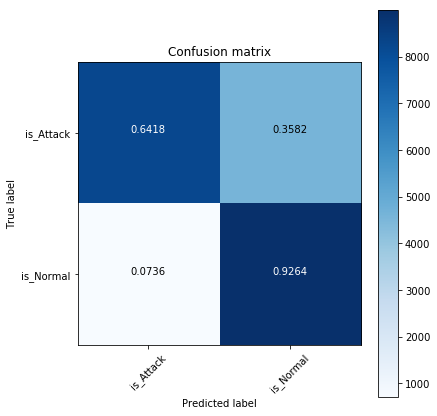

In [10]:
plot(actual_value = y_actual, pred_value = y_pred)

In [11]:
predictions.to_pickle("dataset/vae_dense_keras_predictions.pkl")
scores.to_pickle("dataset/vae_dense_keras_scores.pkl")